Package import

In [1]:
import rioxarray
from rioxarray.merge import merge_arrays
import xarray
from rasterio.features import shapes, geometry_mask
from shapely import geometry
from shapely.geometry import shape, mapping, MultiPolygon
from rasterio.mask import mask
import rasterio
import numpy as np

Specify data source

In [2]:
filepath = '/Users/eslt0101/Data/eScience/IceShelves/TestDataSet/S2_comp_first.tif'


load file as xarray.DataArray

In [3]:
bands = rioxarray.open_rasterio(filepath)

inspect DataArray object

In [4]:
bands


<xarray.DataArray (band: 3, y: 10002, x: 10004)>
[300180024 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1 2 3
  * y            (y) float64 -2.667e+05 -2.667e+05 ... -3.667e+05 -3.667e+05
  * x            (x) float64 -1.654e+06 -1.654e+06 ... -1.554e+06 -1.554e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('B4_first', 'B3_first', 'B2_first')
    grid_mapping:  spatial_ref

bounds and crs of DataArray

In [5]:
bands.rio.bounds()


(-1653920.0, -366670.0, -1553880.0, -266650.0)

In [6]:
bands.rio.crs

CRS.from_epsg(3031)

Define toy polygons for testing. 2 Square boxes. Defined usiing shapely

In [7]:
p1=geometry.Point([-1601000.0, -300000.0])
p2=geometry.Point([-1601000.0, -280000.0])
p3=geometry.Point([-1580000.0, -280000.0])
p4=geometry.Point([-1580000.0, -300000.0])
plist1 = [p1,p2,p3,p4]

p5=geometry.Point([-1651000.0, -360000.0])
p6=geometry.Point([-1651000.0, -350000.0])
p7=geometry.Point([-1640000.0, -350000.0])
p8=geometry.Point([-1640000.0, -360000.0])
plist2 = [p5,p6,p7,p8]

In [8]:
poly1 = geometry.Polygon([[p.x,p.y] for p in plist1])
poly2 = geometry.Polygon([[p.x,p.y] for p in plist2])

In [9]:
type(poly1)

shapely.geometry.polygon.Polygon

Convert to georegistered polygons and group together

In [10]:
from geopandas import GeoSeries

In [11]:
polys = GeoSeries([poly1,poly2],crs=bands.spatial_ref.crs_wkt)

In [12]:
polys

0    POLYGON ((-1601000.000 -300000.000, -1601000.0...
1    POLYGON ((-1651000.000 -360000.000, -1651000.0...
dtype: geometry

In [13]:
#import json
#from shapely.wkt import loads
#import shapely.geometry as geometry


create mask based on geometry. Invert mask to select pixels WITHIN bounds. ATTENTION possible to select on touch or center inclusion

In [14]:
mmask = geometry_mask(polys,out_shape=(len(bands.y),len(bands.x)),transform=bands.rio.transform(),invert=True)


Inspect data type of mask -> ndarray

In [15]:
mmask = np.expand_dims(mmask,axis=0)

In [16]:
mmask.shape


(1, 10002, 10004)

In [17]:
m2mask = mmask.astype(np.dtype('uint16'))

In [18]:
m2mask

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint16)

mask is boolean. Convert to integer representation true==1 false==0

convert mask to DataArray. import coordinates from bands 

In [19]:
amask= xarray.DataArray(data=m2mask,dims=['band','y','x'],coords={'band':[0],'y':bands[0].coords['y'],'x':bands[0].coords['x']})


In [20]:
amask

<xarray.DataArray (band: 1, y: 10002, x: 10004)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint16)
Coordinates:
  * band     (band) int64 0
  * y        (y) float64 -2.667e+05 -2.667e+05 ... -3.667e+05 -3.667e+05
  * x        (x) float64 -1.654e+06 -1.654e+06 ... -1.554e+06 -1.554e+06

Add attributes and projection, crs from bands object

In [21]:
from rioxarray.rioxarray import _add_attrs_proj

In [22]:
import matplotlib.pyplot as plt

In [23]:
from matplotlib.pyplot import imshow

inspect mask

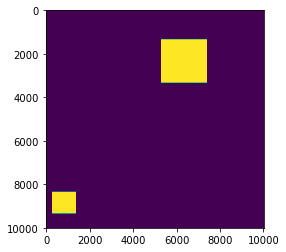

In [25]:
imshow(amask[0])

In [26]:
_add_attrs_proj(amask,bands[0])

<xarray.DataArray (band: 1, y: 10002, x: 10004)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint16)
Coordinates:
  * band         (band) int64 0
  * y            (y) float64 -2.667e+05 -2.667e+05 ... -3.667e+05 -3.667e+05
  * x            (x) float64 -1.654e+06 -1.654e+06 ... -1.554e+06 -1.554e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('B4_first', 'B3_first', 'B2_first')
    grid_mapping:  spatial_ref

In [28]:
out=xarray.concat([bands,amask],'band')

In [29]:
out

<xarray.DataArray (band: 4, y: 10002, x: 10004)>
array([[[ 9248,  9280,  9488, ...,  9232,  9232,  9344],
        [ 9336,  9480,  9392, ...,  9200,  9280,  9328],
        [ 9344,  9368,  9232, ...,  9240,  9320,  9296],
        ...,
        [  370,   361,   416, ...,  9624,  9640,  9584],
        [  386,   398,   365, ...,  9680,  9608,  9616],
        [  430,   347,   404, ...,  9624,  9632,  9632]],

       [[ 9880,  9896,  9984, ...,  9496,  9496,  9608],
        [ 9856,  9872,  9840, ...,  9440,  9504,  9616],
        [ 9784,  9784,  9768, ...,  9496,  9552,  9592],
        ...,
        [  461,   438,   506, ...,  9920,  9896,  9784],
        [  498,   472,   546, ...,  9920,  9856,  9816],
        [  512,   554,   478, ...,  9808,  9808,  9880]],

       [[10072, 10088, 10160, ...,  9584,  9696,  9704],
        [10016, 10104, 10048, ...,  9584,  9720,  9752],
        [ 9944,  9968,  9888, ...,  9664,  9808,  9752],
        ...,
        [  744,   735,   770, ...,  9992,  9904,  9800],
        [  776,   773,   814, ...,  9968,  9920,  9920],
        [  726,   785,   778, ...,  9872,  9880,  9992]],

       [[    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        ...,
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]]], dtype=uint16)
Coordinates:
  * band         (band) int64 1 2 3 0
  * y            (y) float64 -2.667e+05 -2.667e+05 ... -3.667e+05 -3.667e+05
  * x            (x) float64 -1.654e+06 -1.654e+06 ... -1.554e+06 -1.554e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('B4_first', 'B3_first', 'B2_first')
    grid_mapping:  spatial_ref